In [1]:
%store -r sub_data

In [2]:
import pandas as pd
import numpy as np
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 

In [4]:
X = sub_data.drop(columns='Health_status')
y = sub_data['Health_status'].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y )

In [5]:
# Apply oversampling to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Add intercept and convert to float (for statsmodels)
X_resampled_const = add_constant(X_resampled).astype(float)
X_test_const = add_constant(X_test).astype(float)

# Fit the logistic regression model on resampled data
logit_model = Logit(y_resampled, X_resampled_const).fit(disp=False)

# Show model summary
print(logit_model.summary())

                           Logit Regression Results                           
Dep. Variable:          Health_status   No. Observations:                 5252
Model:                          Logit   Df Residuals:                     5226
Method:                           MLE   Df Model:                           25
Date:                Wed, 30 Apr 2025   Pseudo R-squ.:                  0.1929
Time:                        12:58:17   Log-Likelihood:                -2938.2
converged:                       True   LL-Null:                       -3640.4
Covariance Type:            nonrobust   LLR p-value:                4.274e-281
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.4663      0.210     -2.216      0.027      -0.879      -0.054
VWA                   0.1629      0.100      1.627      0.104      -0.033       0.359
MWA                   0.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [6]:
# Predict probabilities on the test set
y_pred_prob = logit_model.predict(X_test_const)

# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.3f}")

AUC: 0.751


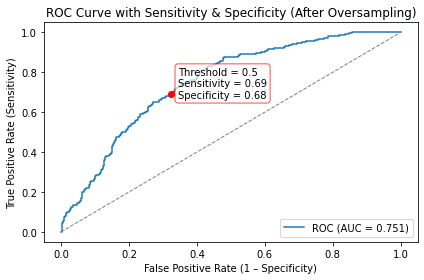

In [7]:
# Choose a threshold (0.5 by default)
th = 0.5
idx = np.argmin(np.abs(thresholds - th))
sens = tpr[idx]
spec = 1 - fpr[idx]

# Plot ROC Curve
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "--", linewidth=1, color="gray")

# Mark chosen point
plt.scatter(fpr[idx], tpr[idx], color="red", zorder=5)
plt.text(
    fpr[idx] + 0.02, tpr[idx] - 0.02,
    f"Threshold = {th}\nSensitivity = {sens:.2f}\nSpecificity = {spec:.2f}",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.7)
)

plt.xlabel("False Positive Rate (1 – Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve with Sensitivity & Specificity (After Oversampling)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import f1_score, classification_report

# 1) Generate binary predictions at your chosen threshold (e.g. 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# 2) Compute F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.2f}")

# 3) (Optional) Full classification breakdown
print(classification_report(y_test, y_pred, digits=2))

F1-score: 0.50
              precision    recall  f1-score   support

           0       0.88      0.68      0.76       657
           1       0.39      0.69      0.50       194

    accuracy                           0.68       851
   macro avg       0.63      0.68      0.63       851
weighted avg       0.77      0.68      0.70       851

